# Tomato Disease Classification - Model Training

This notebook trains a CNN model to classify tomato leaf diseases.

**Disease Classes:**
1. Bacterial Spot
2. Early Blight
3. Healthy
4. Late Blight
5. Leaf Mold
6. Septoria Leaf Spot
7. Spider Mites
8. Target Spot
9. Mosaic Virus
10. Yellow Leaf Curl Virus

## 1. Import Libraries

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Configuration

In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 15

# Path to tomato dataset
DATASET_PATH = "TomatoData"

# Only include tomato folders
TOMATO_CLASSES = [
    "Tomato_Bacterial_spot",
    "Tomato_Early_blight",
    "Tomato_healthy",
    "Tomato_Late_blight",
    "Tomato_Leaf_Mold",
    "Tomato_Septoria_leaf_spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite",
    "Tomato__Target_Spot",
    "Tomato__Tomato_mosaic_virus",
    "Tomato__Tomato_YellowLeaf__Curl_Virus"
]

print(f"Number of classes: {len(TOMATO_CLASSES)}")

Number of classes: 10


## 3. Load Dataset

In [21]:
# Create a dataset from tomato folders only
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=TOMATO_CLASSES
)

class_names = dataset.class_names
print(f"Classes: {class_names}")
print(f"Total batches: {len(dataset)}")

Found 16011 files belonging to 10 classes.
Classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Total batches: 501


## 4. Visualize Sample Images

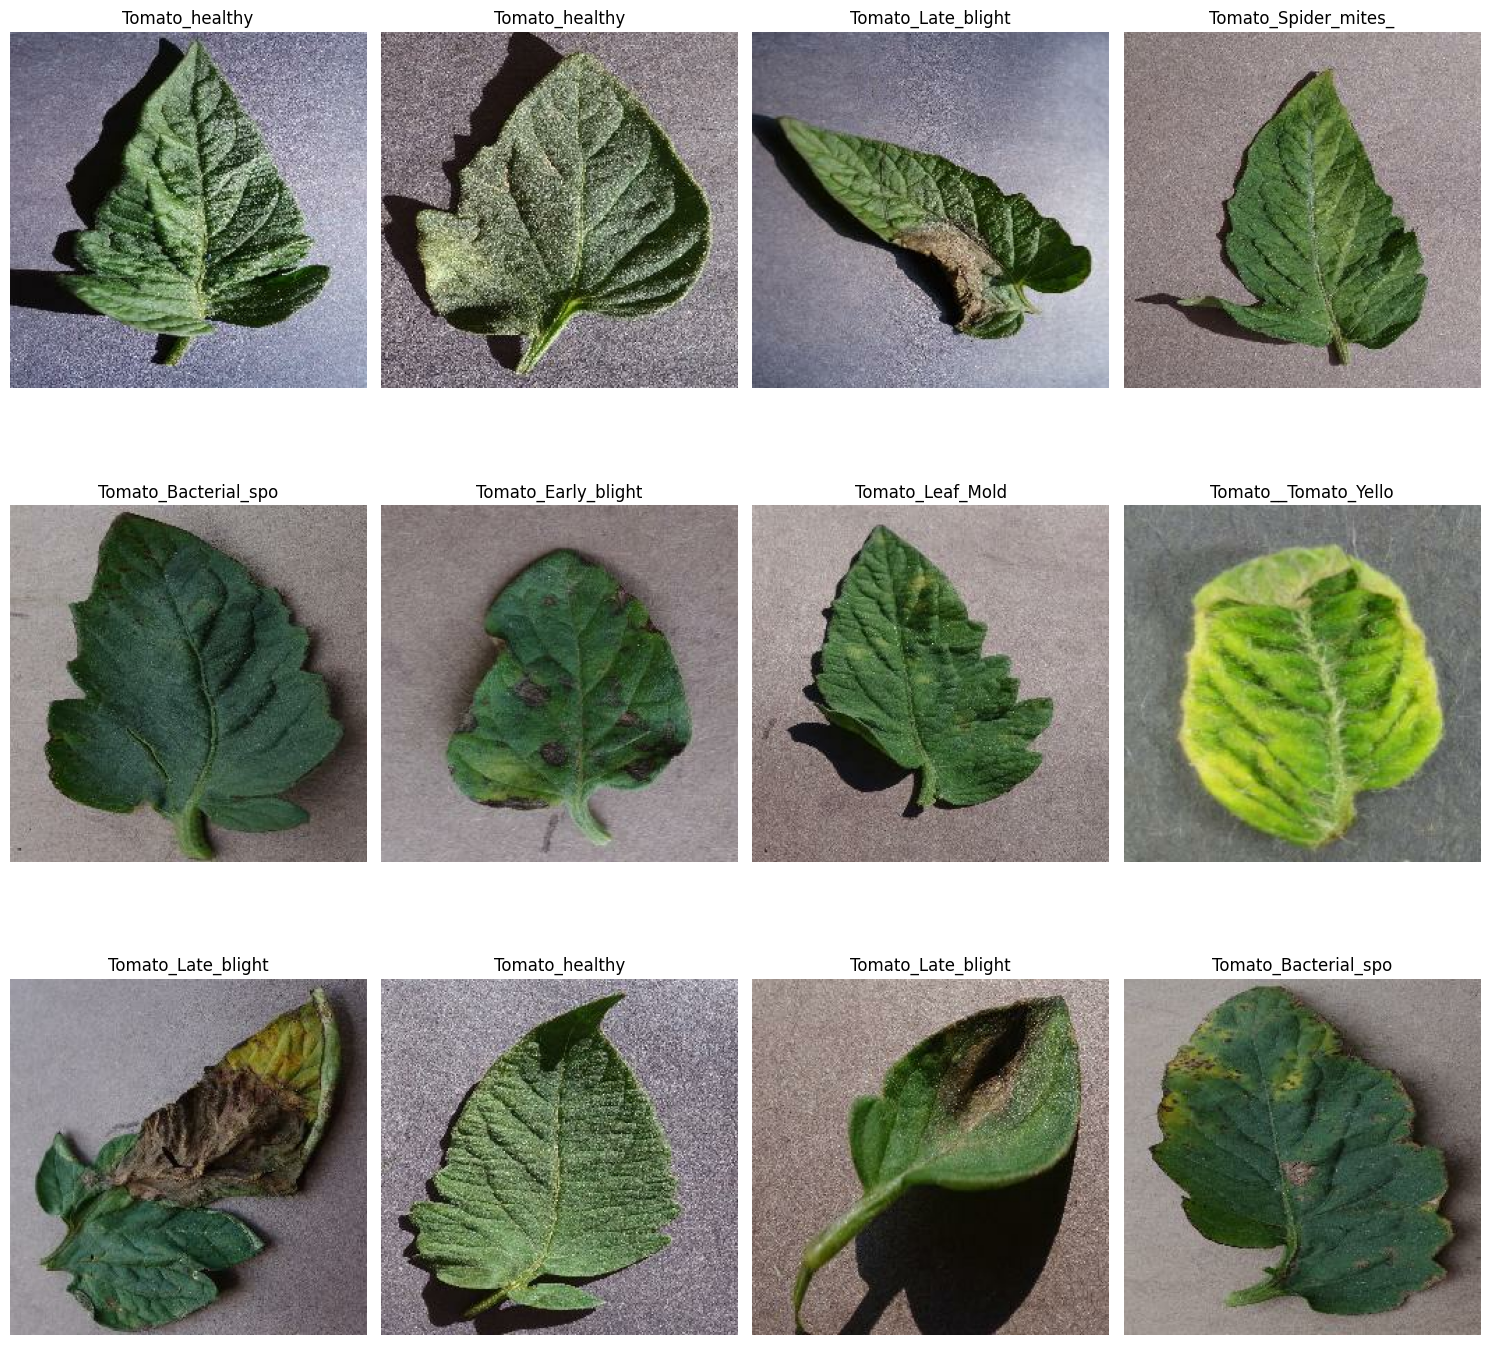

In [22]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(min(12, len(image_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]][:20])  # Truncate long names
        plt.axis("off")
plt.tight_layout()
plt.show()

## 5. Split Dataset (Train/Val/Test)

In [23]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

print(f"Train batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Train batches: 400
Validation batches: 50
Test batches: 51


## 6. Optimize Dataset Performance

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## 7. Data Augmentation

In [25]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

## 8. Build CNN Model

In [26]:
n_classes = len(TOMATO_CLASSES)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

## 9. Compile Model

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## 10. Train Model

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/15
400/400 [==============================] - 396s 892ms/step - loss: 1.7962 - accuracy: 0.3617 - val_loss: 1.6018 - val_accuracy: 0.4281
Epoch 2/15
400/400 [==============================] - 363s 906ms/step - loss: 1.3609 - accuracy: 0.5267 - val_loss: 2.6868 - val_accuracy: 0.4038
Epoch 3/15
400/400 [==============================] - 345s 864ms/step - loss: 1.0555 - accuracy: 0.6336 - val_loss: 1.9534 - val_accuracy: 0.4394
Epoch 4/15
400/400 [==============================] - 318s 795ms/step - loss: 0.8440 - accuracy: 0.7114 - val_loss: 1.6966 - val_accuracy: 0.5138
Epoch 5/15
400/400 [==============================] - 333s 833ms/step - loss: 0.6814 - accuracy: 0.7689 - val_loss: 0.9534 - val_accuracy: 0.6662
Epoch 6/15
400/400 [==============================] - 317s 793ms/step - loss: 0.5908 - accuracy: 0.8013 - val_loss: 0.9087 - val_accuracy: 0.6975
Epoch 7/15
400/400 [==============================] - 318s 794ms/step - loss: 0.5253 - accuracy: 0.8213 - val_loss: 0.9104 -

## 11. Evaluate Model

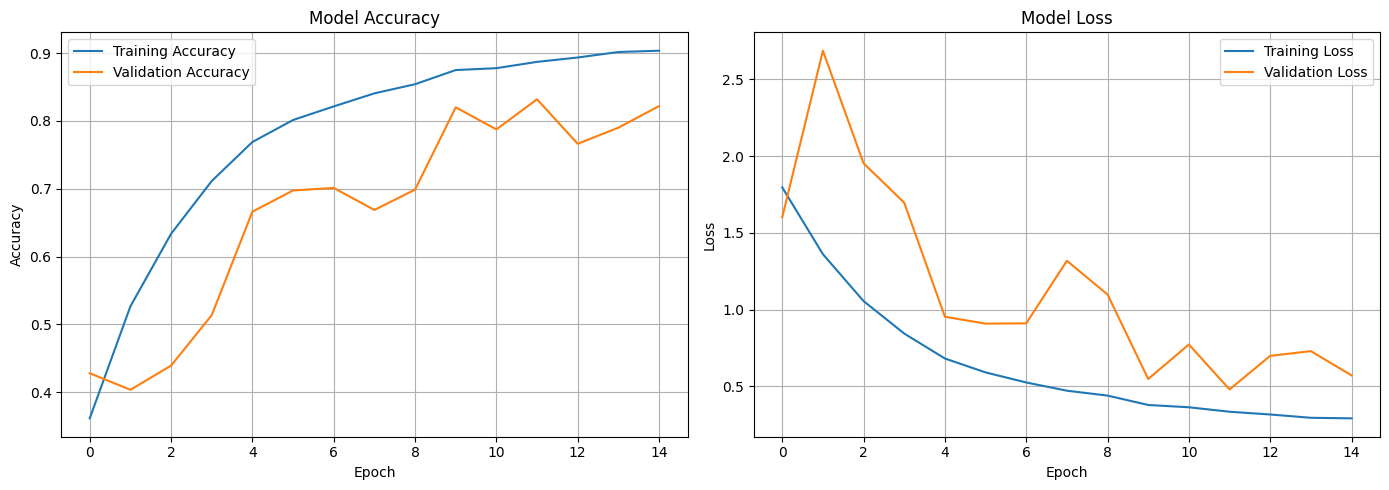

In [29]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [30]:
# Test accuracy
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

51/51 [==============================] - 46s 121ms/step - loss: 0.6245 - accuracy: 0.8150

Test Accuracy: 81.50%
Test Loss: 0.6245


## 12. Save Model

In [32]:
# Save as .h5 file first (more reliable)
model.save("tomatoes.h5")
print("Model saved to: tomatoes.h5")

# Then try SavedModel format with a different path
import os
save_path = "../saved_models/tomato/2"
os.makedirs(save_path, exist_ok=True)
model.save(save_path)
print(f"Model saved to: {save_path}")

Model saved to: tomatoes.h5


INFO:tensorflow:Assets written to: ../saved_models/tomato/2\assets


INFO:tensorflow:Assets written to: ../saved_models/tomato/2\assets


Model saved to: ../saved_models/tomato/2


## 13. Test Prediction

In [ ]:
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    return predicted_class, confidence

# Test on a sample image
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        color = "green" if predicted_class == actual_class else "red"
        plt.title(f"Pred: {predicted_class[:15]}\nActual: {actual_class[:15]}\nConf: {confidence:.2%}", color=color)
        plt.axis("off")

plt.tight_layout()
plt.show()

## 14. Summary

**Next Steps:**
1. Update the API to load both potato and tomato models
2. Update the frontend to allow plant selection
3. Add tomato sample images for testing